01. Initialization

In [8]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ClassificationReport
import os
import pandas as pd
from imblearn.over_sampling import SMOTE
import time
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import json

folder = os.path.join("/", "RanD", "CREMEv2_Result", "20230310", "logs_working", "label_traffic")

if os.path.exists(folder):
    print("Path is exist!!!")
    filename_label = 'label_traffic.csv'
    filename_ready = 'label_traffic_ready.csv'
    filename_train = 'label_traffic_train.csv'
    label_technique = 'labels_technique.json'
    label_lifecycle = 'labels_lifecycle.json'
else:
    print("Path is not exist!!!")

Path is exist!!!


In [9]:
df = pd.read_csv(os.path.join(folder, filename_train))
model_folder = "model_traffic_calculation"

label_origin = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label'])
X = X.to_numpy()
# X = X.reshape(-1)
y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)

In [3]:
def model_score(X_train, y_train, X_test, y_test, estimator_name, estimator, **kwargs):
    model = estimator
    model_filename = os.path.join(model_folder, estimator_name)
    print("=========================================")
    if os.path.exists(model_filename):
        print("Load model {}".format(estimator.__class__.__name__))
        model = pickle.load(open(model_filename, 'rb'))
    else:
        print("Train model {}".format(estimator.__class__.__name__))
        model.fit(X_train, y_train, **kwargs)
        pickle.dump(model, open(model_filename, 'wb'))
    print("=========================================")
    expected = y_test
    predicted = model.predict(X_test)
    
    print("===== Score for {} model =====".format(estimator.__class__.__name__))
    print("Accuracy : {:.4f}".format(accuracy_score(expected, predicted)))
    print("Precision : {:.4f}".format(precision_score(expected, predicted, average='weighted',zero_division=0)))
    print("Recall : {:.4f}".format(recall_score(expected, predicted, average='weighted',zero_division=0)))
    print("F1_score : {:.4f}".format(f1_score(expected, predicted, average='weighted',zero_division=0)))

In [4]:
def model_auroc(X_train, X_test, y_train, y_test, estimator_name, estimator, class_label, **kwargs):
    # model_filename = os.path.join(model_folder, estimator_name)
    # model = pickle.load(open(model_filename, 'rb'))
    
    visualizer = ROCAUC(model, classes=class_label)
    
    visualizer.fit(X_train, y_train)
    auroc_score = visualizer.score(X_test, y_test,
                                   )
    print("Macro AUROC score: {:.4f}".format(auroc_score))
    visualizer.show()
    
    
    

In [10]:
r_state = 42
core = -1
class_label = list(label_origin)



# print("Train Test Split")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=r_state)

# print("Data balancing")
X_train, y_train = SMOTE(n_jobs=-1, random_state=r_state).fit_resample(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [6]:
models = {}

models['DT'] = DecisionTreeClassifier()
models['RF'] = RandomForestClassifier(n_jobs=core)
# models['AB'] = AdaBoostClassifier()
models['GB'] = GradientBoostingClassifier()
models['XGB'] = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)

Load model DecisionTreeClassifier
===== Score for DecisionTreeClassifier model =====
Accuracy : 0.9550
Precision : 0.9579
Recall : 0.9550
F1_score : 0.9562
Macro AUROC score: 0.9604


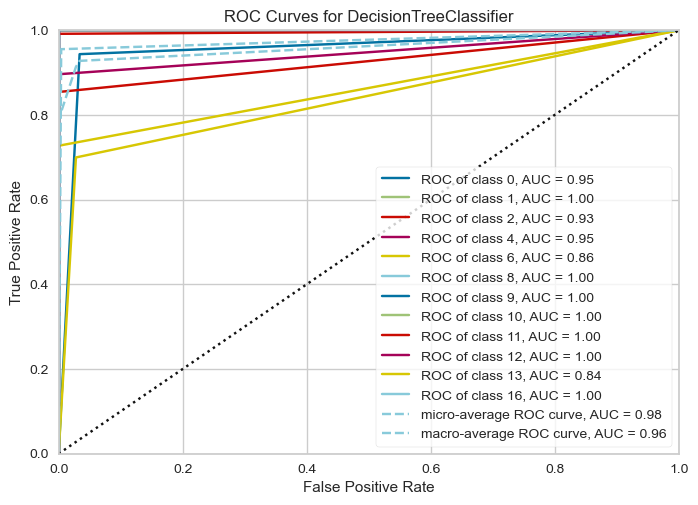

Load model RandomForestClassifier
===== Score for RandomForestClassifier model =====
Accuracy : 0.9475
Precision : 0.9597
Recall : 0.9475
F1_score : 0.9516
Macro AUROC score: 0.9899


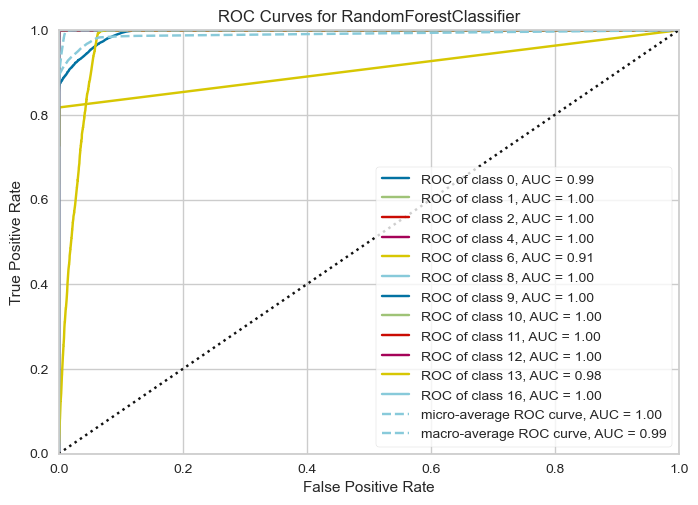

Load model GradientBoostingClassifier
===== Score for GradientBoostingClassifier model =====
Accuracy : 0.9399
Precision : 0.9687
Recall : 0.9399
F1_score : 0.9475
Macro AUROC score: 0.9975


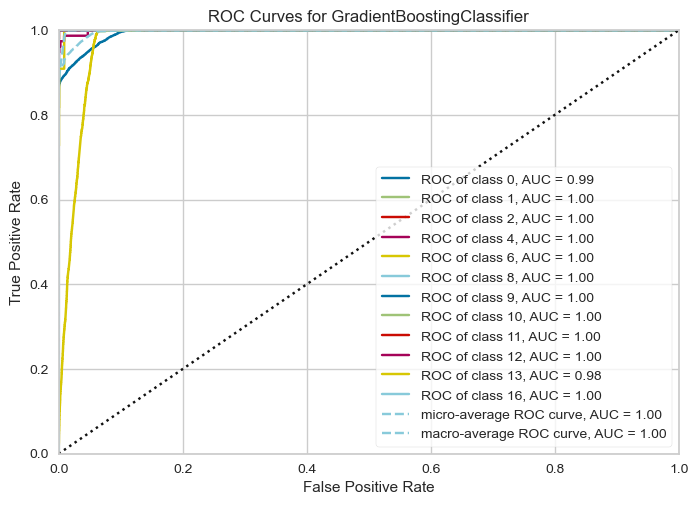

Load model XGBClassifier
===== Score for XGBClassifier model =====
Accuracy : 0.9493
Precision : 0.9703
Recall : 0.9493
F1_score : 0.9550
Macro AUROC score: 0.9980


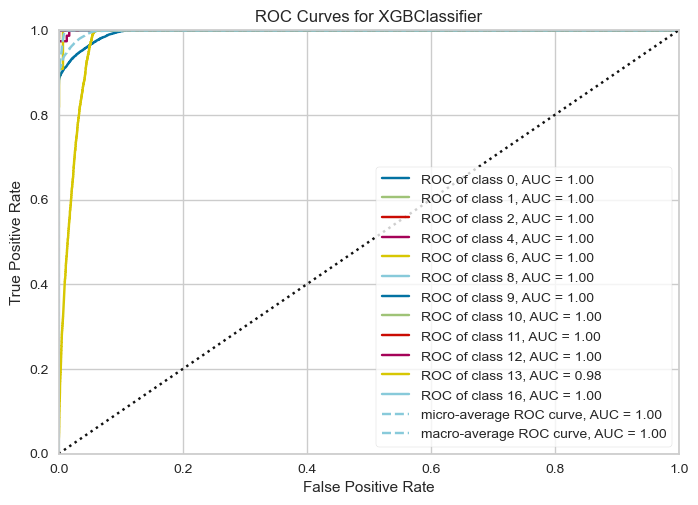

In [7]:
for i, (name, model) in enumerate(models.items()):
    model_score(X_train, y_train, X_test, y_test, name, model)
    model_auroc(X_train, X_test, y_train, y_test, name, model, class_label)

Macro AUROC score: 0.9980


NameError: name 'visualizer' is not defined

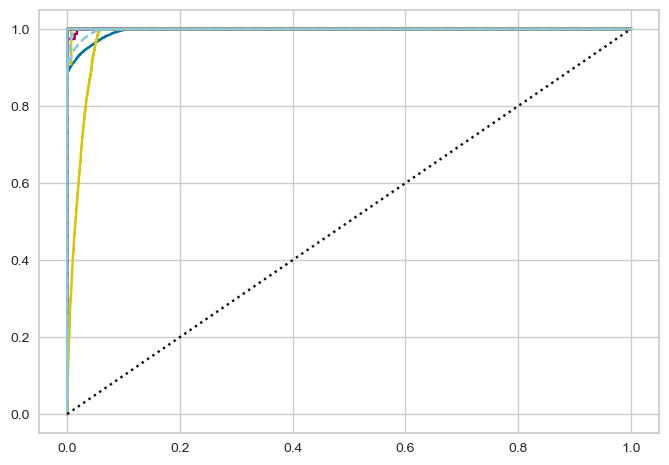

In [11]:
visualizer_xgb = ROCAUC(XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core), classes=class_label)
    
visualizer_xgb.fit(X_train, y_train)
auroc_score_xgb = visualizer_xgb.score(X_test, y_test,
                                )
print("Macro AUROC score: {:.4f}".format(auroc_score_xgb))
visualizer.show()